In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

In [2]:
housing = pd.read_csv('housing_prices_numeric.csv')

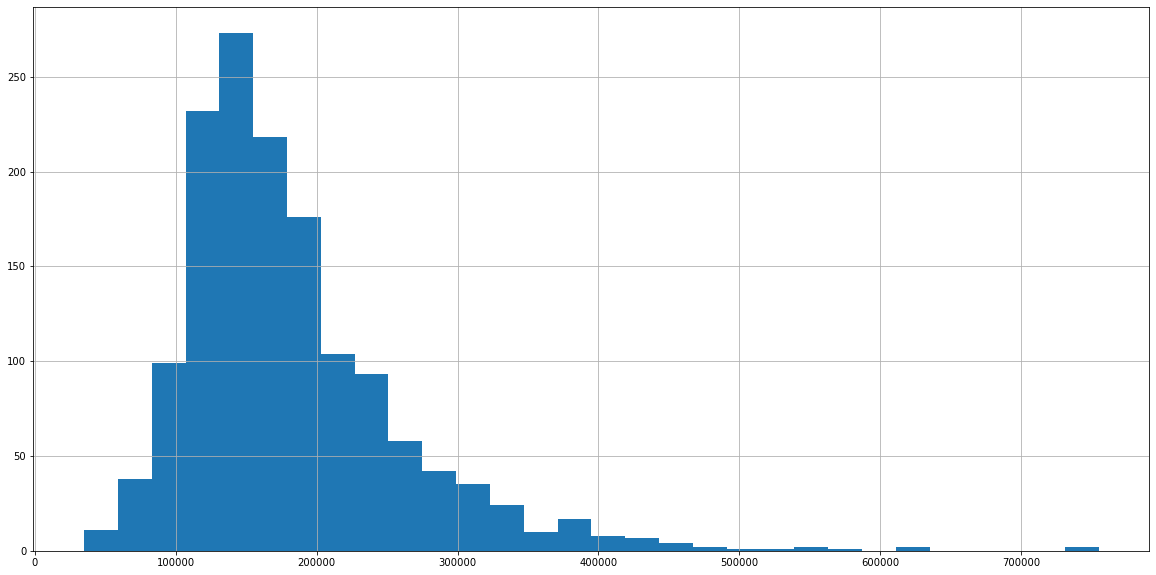

In [3]:
# distribution of house prices
housing.SalePrice.hist(bins=30, figsize=(20,10));

In [4]:
housing.drop_duplicates(inplace=True)
housing.drop(['SaleType', 'SaleCondition', 'MoSold', 'YrSold'], axis=1, inplace=True)
housing = housing[housing['MasVnrArea'].notna()].copy()
ordinal_columns = ["LotShape", "Utilities", "LandSlope", "ExterQual", "ExterCond", 
            "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
            "HeatingQC", "Electrical", "KitchenQual", "Functional", "FireplaceQu",
            "GarageFinish", "GarageQual", "GarageCond", "Fence", "PoolQC"]
LotShape_cats = ["Reg", "IR1", "IR2", "IR3"]
Utilities_cats = ["AllPub", "NoSewr", "NoSeWa", "ELO"]
LandSlope_cats = ["Gtl", "Mod", "Sev"]
ExterQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
BsmtFinType2_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
HeatingQC_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
Electrical_cats = ["N_A", "Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]
KitchenQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
Functional_cats = ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"]
FireplaceQu_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_cats = ["N_A", "Unf", "RFn", "Fin"]
GarageQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
Fence_cats = ["N_A", "MnWw", "GdWo", "MnPrv", "GdPrv"]
PoolQC_cats = ["N_A", "Fa", "TA", "Gd", "Ex"]
cats_ord = [LotShape_cats, Utilities_cats, LandSlope_cats, ExterQual_cats,
            ExterCond_cats, BsmtQual_cats, BsmtCond_cats, BsmtExposure_cats,
            BsmtFinType1_cats, BsmtFinType2_cats, HeatingQC_cats, Electrical_cats,
            KitchenQual_cats, Functional_cats, FireplaceQu_cats, GarageFinish_cats,
            GarageQual_cats, GarageCond_cats, Fence_cats, PoolQC_cats]

# [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [5]:
from sklearn.tree import DecisionTreeRegressor

In [6]:
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]

def impute_categ_nulls(df):
    df = df.fillna("N_A")
    return df

cat_imputer = FunctionTransformer(impute_categ_nulls, validate=False)

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_features_ordinal = ordinal_columns
categorical_transformer_ordinal = OrdinalEncoder(categories=cats_ord)
categorical_features_onehot = list(set(list(X.select_dtypes(include=["object"]))) - set(ordinal_columns))
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ordinal", categorical_transformer_ordinal, categorical_features_ordinal),
        ("cat_onehot", categorical_transformer_onehot, categorical_features_onehot),
    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)

cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    VarianceThreshold(),
    StandardScaler(),
    # Changed to f_regression instead of f_classif as we now have a regression task, not a classification task
    SelectKBest(f_regression),
    DecisionTreeRegressor()
)

pipe_params = {
    'selectkbest__k': [10, 20, 40],
    'decisiontreeregressor__criterion': ['friedman_mse', 'absolute_error', 'poisson'],
    'decisiontreeregressor__max_depth': [5, 10, 20, 40],
    'decisiontreeregressor__min_samples_split': [2, 4, 6],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 5]
}

# Changed the scoring to neg_root_mean_squared_error instead of f1 as we now have a regression task, not a classification task
clf = GridSearchCV(final_pipe, pipe_params, cv = 10, scoring='neg_root_mean_squared_error')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

{'decisiontreeregressor__criterion': 'absolute_error',
 'decisiontreeregressor__max_depth': 10,
 'decisiontreeregressor__min_samples_leaf': 2,
 'decisiontreeregressor__min_samples_split': 2,
 'selectkbest__k': 40}

In [7]:
from sklearn.metrics import mean_absolute_error

y_pred = clf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae

26261.443298969072

In [24]:
print(f'According to the mean absolute error, we are on average ${mae:.2f} off the actual price')

According to the mean absolute error, we are on average $16172.73 off the actual price


In [9]:
mean_price = round(housing.SalePrice.mean())

relative_error = mae / mean_price
relative_error

0.1454001234613353

In [10]:
print(f'Relative Error shows we are on average {relative_error * 100:.2f}% off of the real price')

Relative Error shows we are on average 14.54% off of the real price


In [11]:
# Error Analysis
X_test_results = X_test.copy()

X_test_results["true_price"] = y_test
X_test_results["predicted_price"] = y_pred
X_test_results["absolute_error"] = abs(X_test_results["true_price"] - X_test_results["predicted_price"])
X_test_results["relative_error"] = X_test_results["absolute_error"] / X_test_results["true_price"]

X_test_results

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,true_price,predicted_price,absolute_error,relative_error
1378,1379,160,RM,21.0,1953,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,83000,87500.0,4500.0,0.054217
483,484,120,RM,32.0,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,164000,153500.0,10500.0,0.064024
1300,1301,60,RL,NaN,10762,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,225000,225500.0,500.0,0.002222
271,272,20,RL,73.0,39104,Pave,NaN,IR1,Low,AllPub,...,0,0,NaN,NaN,NaN,0,241500,167000.0,74500.0,0.308489
279,280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,192000,205000.0,13000.0,0.067708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1254,60,RL,NaN,17542,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,294000,225500.0,68500.0,0.232993
1387,1388,50,RM,60.0,8520,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,136000,256000.0,120000.0,0.882353
248,249,60,RL,72.0,11317,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,180000,188500.0,8500.0,0.047222
962,963,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,155000,176000.0,21000.0,0.135484


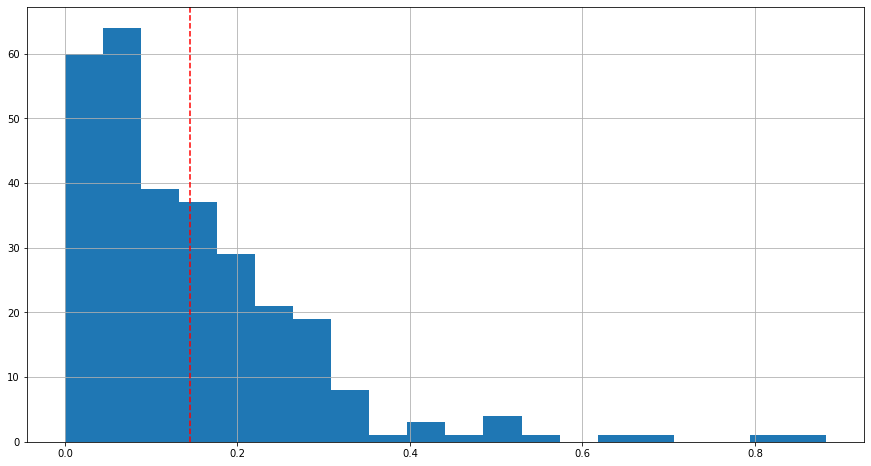

In [12]:
# Histogram of relative error
ax = X_test_results.relative_error.hist(bins=20, figsize=(15,8))
ax.axvline(relative_error, color="red", linestyle="--");

# [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [13]:
from sklearn.linear_model import Ridge

In [14]:
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]

def impute_categ_nulls(df):
    df = df.fillna("N_A")
    return df

cat_imputer = FunctionTransformer(impute_categ_nulls, validate=False)

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_features_ordinal = ordinal_columns
categorical_transformer_ordinal = OrdinalEncoder(categories=cats_ord)
categorical_features_onehot = list(set(list(X.select_dtypes(include=["object"]))) - set(ordinal_columns))
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ordinal", categorical_transformer_ordinal, categorical_features_ordinal),
        ("cat_onehot", categorical_transformer_onehot, categorical_features_onehot),
    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    VarianceThreshold(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)

pipe_params = {
    'selectkbest__k': [10, 20, 40],
    'ridge__alpha': [0.1, 1.0, 10.0],
    'ridge__solver': ['cholesky', 'sparse_cg', 'lsqr']
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 10, scoring='neg_root_mean_squared_error')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

{'ridge__alpha': 10.0, 'ridge__solver': 'cholesky', 'selectkbest__k': 40}

In [15]:
y_pred = clf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae

21298.85911975719

In [16]:
relative_error = mae / mean_price
relative_error

0.11792408780974555

In [17]:
X_test_results = X_test.copy()

X_test_results["true_price"] = y_test
X_test_results["predicted_price"] = y_pred
X_test_results["absolute_error"] = abs(X_test_results["true_price"] - X_test_results["predicted_price"])
X_test_results["relative_error"] = X_test_results["absolute_error"] / X_test_results["true_price"]

X_test_results

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,true_price,predicted_price,absolute_error,relative_error
1378,1379,160,RM,21.0,1953,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,83000,102706.915845,19706.915845,0.237433
483,484,120,RM,32.0,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,164000,139111.522259,24888.477741,0.151759
1300,1301,60,RL,NaN,10762,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,225000,244306.535478,19306.535478,0.085807
271,272,20,RL,73.0,39104,Pave,NaN,IR1,Low,AllPub,...,0,0,NaN,NaN,NaN,0,241500,201849.627619,39650.372381,0.164184
279,280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,192000,211113.374408,19113.374408,0.099549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1254,60,RL,NaN,17542,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,294000,262305.929252,31694.070748,0.107803
1387,1388,50,RM,60.0,8520,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,136000,199086.591018,63086.591018,0.463872
248,249,60,RL,72.0,11317,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,180000,190125.213536,10125.213536,0.056251
962,963,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,155000,186049.679189,31049.679189,0.200321


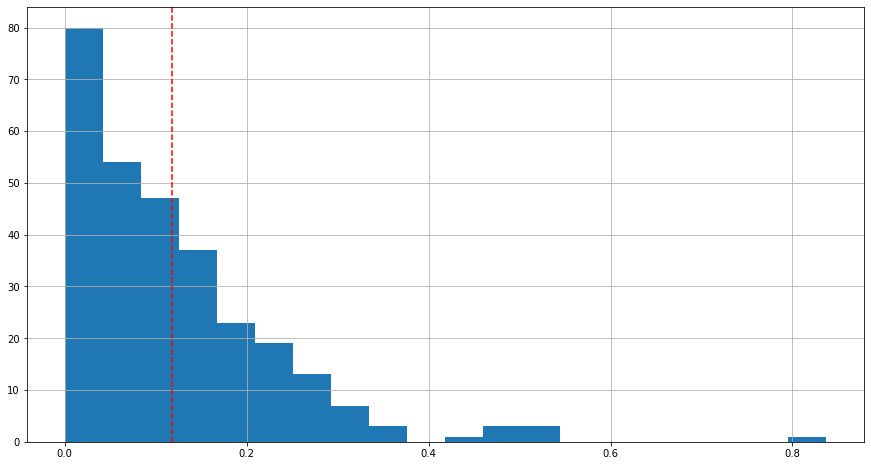

In [18]:
ax = X_test_results.relative_error.hist(bins=20, figsize=(15,8))
ax.axvline(relative_error, color="red", linestyle="--");

# [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]

def impute_categ_nulls(df):
    df = df.fillna("N_A")
    return df

cat_imputer = FunctionTransformer(impute_categ_nulls, validate=False)

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_features_ordinal = ordinal_columns
categorical_transformer_ordinal = OrdinalEncoder(categories=cats_ord)
categorical_features_onehot = list(set(list(X.select_dtypes(include=["object"]))) - set(ordinal_columns))
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ordinal", categorical_transformer_ordinal, categorical_features_ordinal),
        ("cat_onehot", categorical_transformer_onehot, categorical_features_onehot),
    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    VarianceThreshold(),
    StandardScaler(),
    SelectKBest(f_regression),
    RandomForestRegressor()
)

pipe_params = {
    'selectkbest__k': [50, 60, 70],
    'randomforestregressor__max_depth': [10, 20, 40],
    'randomforestregressor__min_samples_split': [2, 3, 5],
    'randomforestregressor__min_samples_leaf': [1, 2, 5]
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 10, scoring='neg_root_mean_squared_error', 
                   error_score='raise')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

{'randomforestregressor__max_depth': 20,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 3,
 'selectkbest__k': 50}

In [21]:
y_pred = clf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae

16172.73152865748

In [22]:
relative_error = mae / mean_price
relative_error

0.08954257137368148

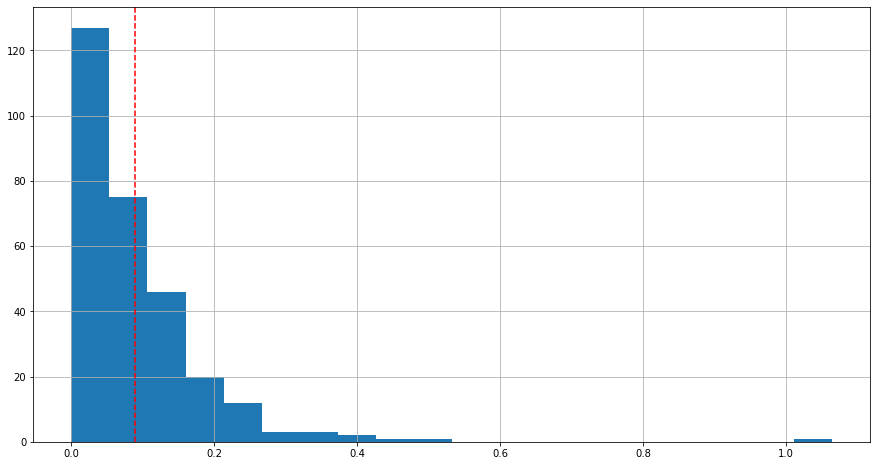

In [23]:
X_test_results = X_test.copy()

X_test_results["true_price"] = y_test
X_test_results["predicted_price"] = y_pred
X_test_results["absolute_error"] = abs(X_test_results["true_price"] - X_test_results["predicted_price"])
X_test_results["relative_error"] = X_test_results["absolute_error"] / X_test_results["true_price"]

ax = X_test_results.relative_error.hist(bins=20, figsize=(15,8))
ax.axvline(relative_error, color="red", linestyle="--");